In [149]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import brier_score_loss

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform, beta
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [150]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv").squeeze()
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv").squeeze()
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv").squeeze()
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv").squeeze()

In [151]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)

In [152]:
datasets = [
    (X1_train, X1_test, y1_train, y1_test, "Bank"),
    (X2_train, X2_test, y2_train, y2_test, "Gym"),
    (X3_train, X3_test, y3_train, y3_test, "Heart Disease"),
    (X4_train, X4_test, y4_train, y4_test, "Titanic")
]
baseline_brier_scores = []


model = RandomForestClassifier(random_state=42)

for X_train, X_test, y_train, y_test, _ in tqdm(datasets, desc="Processing datasets"):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)
    baseline_brier_scores.append(brier)

for i, (brier, (_, _, _, _, dataset_name)) in enumerate(zip(baseline_brier_scores, datasets), 1):
    print(f"Dataset {i} ({dataset_name}): Baseline Brier score = {brier:.4f}")

Processing datasets: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

Dataset 1 (Bank): Baseline Brier score = 0.1892
Dataset 2 (Gym): Baseline Brier score = 0.1819
Dataset 3 (Heart Disease): Baseline Brier score = 0.1067
Dataset 4 (Titanic): Baseline Brier score = 0.1520


In [153]:
N_ITER = 100
RANDOM_STATE = 42
SCORER = 'neg_brier_score'  # maximize negative value because in standard brier score the lower, the better
WINDOW_SIZE = 10
ABS_TOL = 0.001 
CV = 5


N_JOBS = -1

In [154]:
param_distributions = {
      'n_estimators': randint(100, 1000),
      'criterion': ['log_loss', 'entropy'], # 'gini', 
      'max_depth': [10, 15, 20, None],  # Limit tree depth
      'min_samples_split': randint(2, 20),      # More restrictive
      'min_samples_leaf': randint(1, 10),       # Prevent tiny leaves
      'max_features': ['sqrt', 0.1, 0.33, 0.5],    # Force feature subsampling
  }

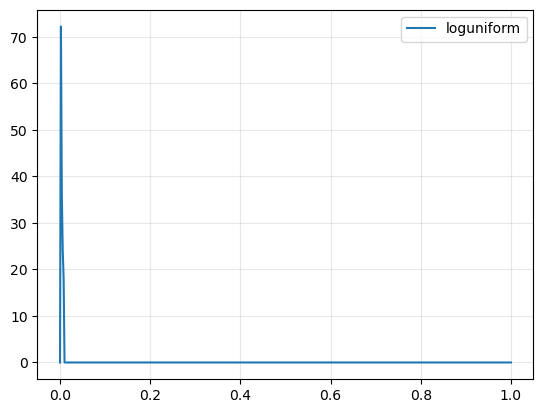

In [155]:
from scipy.stats import loguniform

x = np.linspace(0, 1, 500)
pdf = loguniform.pdf(x, 1e-5, 1e-2)

plt.plot(x, pdf, label='loguniform')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [156]:
model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    scoring=SCORER,
    cv=CV,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    refit=True ###
)

tuned_brier_scores = []
best_params_list = []
cv_results_list = []

In [157]:
def chart_random(stabilized_at, brier_per_iter, iters, best_so_far, dataset_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(iters, brier_per_iter, s=12, alpha=0.6, label='Brier per iteration')
    plt.plot(iters, best_so_far, linewidth=2, label='Best so far')
    if stabilized_at is not None:
        plt.axvline(stabilized_at, linestyle='--', linewidth=1, label=f'Stabilized at {stabilized_at}')
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title(f'Brier per Random Search iteration and best-so-far for {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    

def detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len = WINDOW_SIZE):
    """
    Szuka pierwszego okna długości 10 takie, że wszystkie 9 kolejnych różnic
    między elementami okna mają wartość absolutną < abs_tol.
    Zwraca (stabilized_at_1based, stabilized_value) lub (None, None).
    """
    arr = np.asarray(best_so_far)
    n = arr.shape[0]
    if n < window_len:
        return None, None

    for start in range(0, n - window_len + 1):
        window = arr[start:start + window_len]
        diffs = np.abs(np.diff(window)) 
        if np.all(diffs < abs_tol):
            return start + 1, float(window[0])
    return None, None

Tuning datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


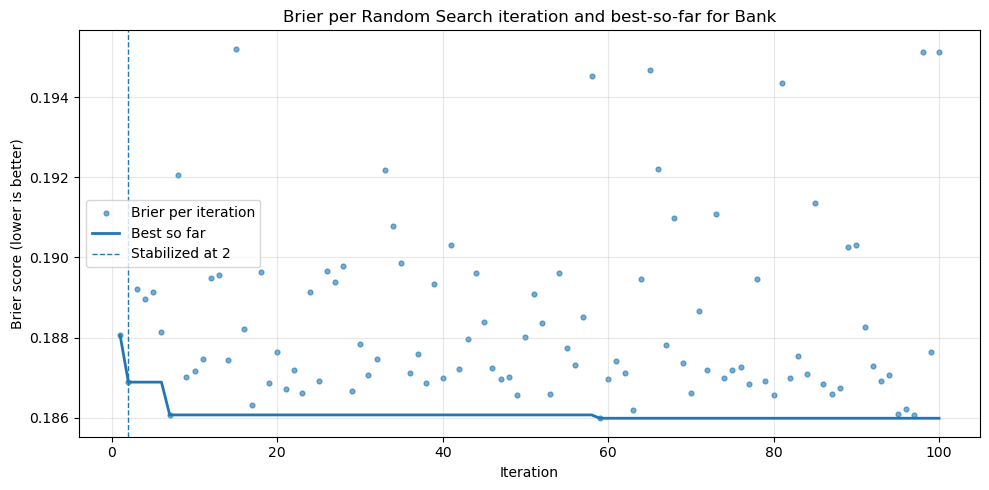

Tuning datasets:  25%|██▌       | 1/4 [18:20<55:01, 1100.65s/it]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


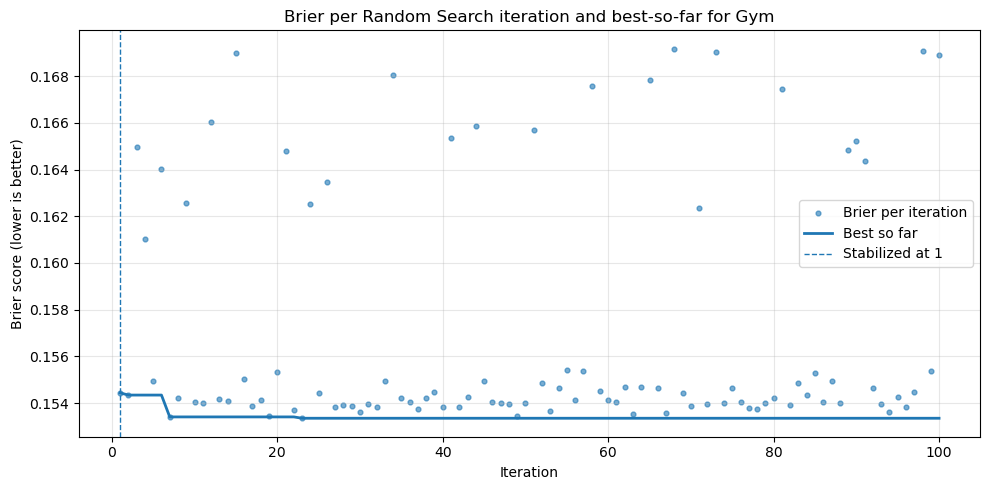

Tuning datasets:  50%|█████     | 2/4 [23:34<21:15, 637.83s/it] 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


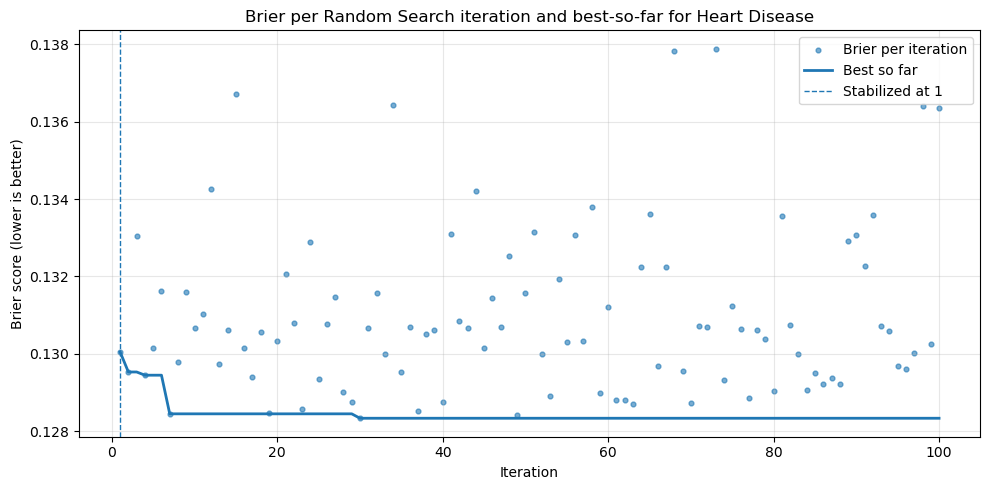

Tuning datasets:  75%|███████▌  | 3/4 [26:45<07:13, 433.87s/it]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


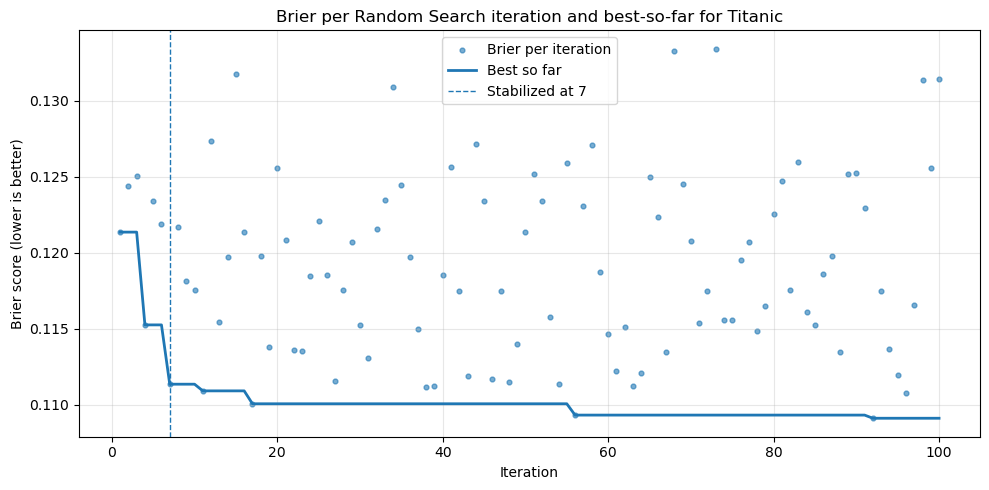

Tuning datasets: 100%|██████████| 4/4 [29:50<00:00, 447.55s/it]


In [158]:
for X_train, X_test, y_train, y_test, dataset_name in tqdm(datasets, desc="Tuning datasets"):
    # Fit the RandomizedSearchCV (or other search object) on training fold
    random_search.fit(X_train, y_train)

    model = random_search.best_estimator_
    
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)

    cv_results = random_search.cv_results_
    best_params = random_search.best_params_.copy()  # dict

    tuned_brier_scores.append(brier)
    best_params_list.append(best_params)
    cv_results_list.append(cv_results)

    
    mean_test_score = -cv_results['mean_test_score']  # Negate if using neg_log_loss
    best_so_far = np.minimum.accumulate(mean_test_score)

    # detect stabilization (1-based iteration returned)
    stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE)
    # Prepare data for plotting
    iters = np.arange(1, len(mean_test_score) + 1)

    # Plot the results for this dataset
    chart_random(stabilized_at, mean_test_score, iters, best_so_far, dataset_name)

In [159]:
# Combine all cv_results into one DataFrame
all_results = []
for i, cv_res in enumerate(cv_results_list):
    df = pd.DataFrame(cv_res)
    dataset_name = datasets[i][4]  # adjust if your dataset tuple differs
    df["dataset"] = dataset_name
    df["brier_score"] = tuned_brier_scores[i]
    all_results.append(df)

# Merge into one full DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

# Keep the most informative columns
cols_to_keep = [
    "dataset",
    "params",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
    "mean_fit_time",
    "mean_score_time",
    "brier_score"
]
existing_cols = [c for c in cols_to_keep if c in all_results_df.columns]
results_to_save = all_results_df[existing_cols]

# Save all model evaluations
results_to_save.to_csv("RandomForestData/all_randomsearch_results.csv", index=False)
print(f"✅ Saved {len(all_results_df)} rows to RandomForestData/all_randomsearch_results.csv")

# Extract best model per dataset
best_rows = all_results_df.loc[all_results_df.groupby("dataset")["rank_test_score"].idxmin()]
best_rows = best_rows.sort_values("dataset").reset_index(drop=True)
best_rows.to_csv("RandomForestData/best_models_summary.csv", index=False)
print(f"✅ Saved {len(best_rows)} best model summaries to RandomForestData/best_models_summary.csv")

# Plot convergence charts
# for i, cv_res in enumerate(cv_results_list):
#     dataset_name = datasets[i][4]
#     cv_results = cv_res
#     mean_test_score = -np.array(cv_results["mean_test_score"])  # negate if using neg metric
#     iters = np.arange(1, len(mean_test_score) + 1)
#     best_so_far = np.minimum.accumulate(mean_test_score)

#     stabilized_at, stabilized_value = detect_stabilization_by_last(
#         best_so_far,
#         abs_tol=ABS_TOL,
#         window_len=WINDOW_SIZE
#     )

#     chart_random(stabilized_at, mean_test_score, iters, best_so_far, dataset_name)

# plt.tight_layout()
# plt.show()


✅ Saved 400 rows to RandomForestData/all_randomsearch_results.csv
✅ Saved 4 best model summaries to RandomForestData/best_models_summary.csv


In [160]:
pd.set_option('display.max_colwidth', 300)


# Ensure we work with a copy
df = pd.read_csv("RandomForestData/all_randomsearch_results.csv")
#df = all_results_df.copy()
# Sort within each dataset by brier_score ascending (lower is better)
df_sorted = df.sort_values(by=["dataset", "mean_test_score"], ascending=[True, False])

# Get top 10 per dataset
top10_per_dataset = df_sorted.groupby("dataset").head(10).reset_index(drop=True)

# Show in console
for dataset_name, subset in top10_per_dataset.groupby("dataset"):
    print(f"\nTop 10 models for dataset: {dataset_name}")
    display(subset[["dataset", "rank_test_score", "mean_test_score", "params"]])



Top 10 models for dataset: Bank


,dataset,rank_test_score,mean_test_score,params
0,Bank,1,-0.185984,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.33, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 739}"
1,Bank,2,-0.186068,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 918}"
2,Bank,3,-0.186076,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 19, 'n_estimators': 134}"
3,Bank,4,-0.186093,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 712}"
4,Bank,5,-0.186186,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 646}"
5,Bank,6,-0.186225,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 941}"
6,Bank,7,-0.186316,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 620}"
7,Bank,8,-0.186572,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 863}"
8,Bank,9,-0.186576,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'min_samples_leaf': 7, 'min_samples_split': 9, 'n_estimators': 919}"
9,Bank,10,-0.186581,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.33, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 727}"



Top 10 models for dataset: Gym


,dataset,rank_test_score,mean_test_score,params
10,Gym,1,-0.153352,"{'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.33, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 838}"
11,Gym,2,-0.153409,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 918}"
12,Gym,3,-0.153431,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 863}"
13,Gym,4,-0.153437,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 478}"
14,Gym,5,-0.153530,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 646}"
15,Gym,6,-0.153596,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.33, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 355}"
16,Gym,7,-0.153620,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 13, 'n_estimators': 789}"
17,Gym,8,-0.153620,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 895}"
18,Gym,9,-0.153649,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.33, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 727}"
19,Gym,10,-0.153689,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 783}"



Top 10 models for dataset: Heart Disease


,dataset,rank_test_score,mean_test_score,params
20,Heart Disease,1,-0.128336,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 895}"
21,Heart Disease,2,-0.128425,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 863}"
22,Heart Disease,3,-0.128450,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 918}"
23,Heart Disease,4,-0.128464,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 478}"
24,Heart Disease,5,-0.128526,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 13, 'n_estimators': 609}"
25,Heart Disease,6,-0.128585,"{'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.33, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 838}"
26,Heart Disease,7,-0.128711,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 646}"
27,Heart Disease,8,-0.128732,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.33, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 738}"
28,Heart Disease,9,-0.128750,"{'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.33, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 484}"
29,Heart Disease,10,-0.128766,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.33, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 781}"



Top 10 models for dataset: Titanic


,dataset,rank_test_score,mean_test_score,params
30,Titanic,1,-0.109103,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 615}"
31,Titanic,2,-0.109310,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 921}"
32,Titanic,3,-0.110055,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 620}"
33,Titanic,4,-0.110779,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 941}"
34,Titanic,5,-0.110905,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.33, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 661}"
35,Titanic,6,-0.111168,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 0.33, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 724}"
36,Titanic,7,-0.111237,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 646}"
37,Titanic,8,-0.111251,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.33, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 741}"
38,Titanic,9,-0.111324,"{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 203}"
39,Titanic,10,-0.111344,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 918}"


In [161]:
for i, (brier, baseline_brier, params, (_, _, _, _, dataset_name)) in enumerate(zip(tuned_brier_scores, baseline_brier_scores, best_params_list, datasets), 1):
    print(f"""
    Dataset {i} ({dataset_name}): 
        Tuned Brier score = {brier:.4f}, Baseline Brier score = {baseline_brier:.4f} \n
    Best parameters:
        n_estimators: {params['n_estimators']:.4f}
        criterion: {params['criterion']}
        max_depth:{params['max_depth']}
        min_samples_split:{params['min_samples_split']}
        min_samples_leaf:{params['min_samples_leaf']}
        max_features:{params['max_features']}
    """)


    Dataset 1 (Bank): 
        Tuned Brier score = 0.1851, Baseline Brier score = 0.1892 

    Best parameters:
        n_estimators: 739.0000
        criterion: entropy
        max_depth:None
        min_samples_split:18
        min_samples_leaf:3
        max_features:0.33
    

    Dataset 2 (Gym): 
        Tuned Brier score = 0.1791, Baseline Brier score = 0.1819 

    Best parameters:
        n_estimators: 838.0000
        criterion: entropy
        max_depth:15
        min_samples_split:2
        min_samples_leaf:3
        max_features:0.33
    

    Dataset 3 (Heart Disease): 
        Tuned Brier score = 0.1084, Baseline Brier score = 0.1067 

    Best parameters:
        n_estimators: 895.0000
        criterion: log_loss
        max_depth:15
        min_samples_split:7
        min_samples_leaf:5
        max_features:sqrt
    

    Dataset 4 (Titanic): 
        Tuned Brier score = 0.1505, Baseline Brier score = 0.1520 

    Best parameters:
        n_estimators: 615.0000
       